<h1>contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#setup" data-toc-modified-id="setup-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>setup</a></span></li><li><span><a href="#neural-network-architecture" data-toc-modified-id="neural-network-architecture-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>neural network architecture</a></span></li><li><span><a href="#data" data-toc-modified-id="data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>data</a></span></li><li><span><a href="#experiments" data-toc-modified-id="experiments-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>experiments</a></span><ul class="toc-item"><li><span><a href="#random-grid-search" data-toc-modified-id="random-grid-search-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>random grid search</a></span></li><li><span><a href="#results" data-toc-modified-id="results-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>results</a></span></li></ul></li></ul></div>

# setup

In [1]:
import datetime
import gc
import json
import os
import pprint
import warnings
from io import BytesIO

import folium
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import tqdm
from folium.plugins import HeatMap
from IPython.display import display
from selenium import webdriver
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import ParameterGrid, train_test_split
from sklearn.preprocessing import MinMaxScaler

import cartopy.crs as ccrs
import cartopy.feature as cfeature

from scipy.interpolate import griddata

mpl.rcParams.update(mpl.rcParamsDefault)
warnings.filterwarnings("ignore")

%matplotlib inline

In [2]:
sns.set_style("whitegrid")

plt.rcParams.update({
    'font.size'       : 9,
    'figure.figsize'  : (3.5, 2.8),
    'figure.dpi'      : 300,
    'savefig.dpi'     : 300,
    'text.usetex'     : True,
    'font.family'     : 'serif',
    'font.serif'      : ['Times New Roman'],
    'axes.labelsize'  : 9,
    'axes.titlesize'  : 9,
    'xtick.labelsize' : 8,
    'ytick.labelsize' : 8,
    'legend.fontsize' : 8,
    'lines.linewidth' : 1,
    'axes.linewidth'  : 1,
    'grid.linestyle'  : '--',
    'grid.linewidth'  : 0.5,
    'grid.alpha'      : 0.8,
})

sns.set_context(
    "paper", 
    rc={
        "font.size"      : 9,
        "axes.titlesize" : 9,
        "axes.labelsize" : 9, 
        'xtick.labelsize': 8,
        'ytick.labelsize': 8
    }
)

In [3]:
experiment_name = "wildfire_spread"
folder_path = f"../data/08_reporting/{experiment_name}"
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

golden_ratio = (np.sqrt(5) - 1) / 2

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# data

In [4]:
BRAZIL_EXTENT = [-74, -34, -34, 6]
SAO_PAULO_EXTENT = [-53, -44, -25, -20]


In [5]:
import netCDF4 as nc

In [55]:
dataset = nc.Dataset("/home/dusoudeth/Downloads/20231116.nc", "r")
print(dataset.variables.keys()) 

dict_keys(['time', 'lon', 'lat', 'rf'])


In [56]:
dataset

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    CDI: Climate Data Interface version 2.2.1 (https://mpimet.mpg.de/cdi)
    Conventions: None
    source: Codigo feito no software NCL 6.6.2
    creation_date: Fri 17 Nov 2023 07:15:58 AM UTC
    link: http://www.inpe.br/queimadas/
    author: Alberto Setzer - alberto.setzer@inpe.br
    codigo: Guilherme Martins - guilherme.martins@inpe.br
    descricao: A nova versão do RF inclui o efeito topográfico e latitude.
    title: Risco de fogo para o dia 20231116
    history: Fri Nov 17 07:16:03 2023: cdo -s -f nc4 -z zip_9 copy /home/queimadas/INPE_FireRiskModel/data/output/2.2/FireRisk-2_2/2023/11//INPE_FireRiskModel_2.2_FireRisk_20231116.nc /home/queimadas/INPE_FireRiskModel/tmp/2nc4.RF.ET.20231116.nc
Fri Nov 17 07:16:00 2023: cdo -s -r -b F32 -setmissval,-999 -settaxis,2023-11-16,00:00:00,1day /home/queimadas/INPE_FireRiskModel/tmp/RF.ET.20231116.nc /home/queimadas/INPE_FireRiskModel/tmp/tmp.RF.ET.202

In [15]:
time = dataset.variables['time'][:]
lon = dataset.variables['lon'][:]
lat = dataset.variables['lat'][:]
rf = dataset.variables['rf'][0, :, :]

dataset.close()


In [24]:
# filter data in brazil soroundings 
lat_min = -34
lat_max = 6
lon_min = -74
lon_max = -34

lat_idx = np.where((lat >= lat_min) & (lat <= lat_max))[0]
lon_idx = np.where((lon >= lon_min) & (lon <= lon_max))[0]

lat = lat[lat_idx]
lon = lon[lon_idx]
rf = rf[lat_idx, :]
rf = rf[:, lon_idx]


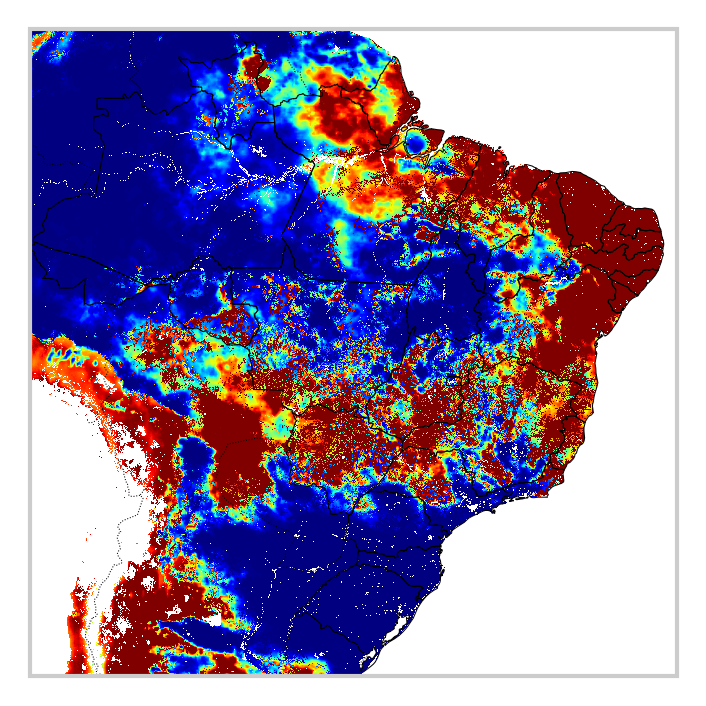

In [32]:
fig = plt.figure()
ax = fig.add_subplot(projection=ccrs.PlateCarree())
ax.set_extent(BRAZIL_EXTENT, crs=ccrs.PlateCarree())

ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.25)
ax.add_feature(cfeature.STATES, linewidth=0.25)

ax.pcolormesh(lon, lat, rf, transform=ccrs.PlateCarree(), cmap='jet')

In [37]:
fig.savefig(f"{folder_path}/rainfall.png", bbox_inches='tight', pad_inches=0.1, dpi=1000)

In [38]:
gc.collect()

5

In [13]:
gdf = gpd.read_file("/home/dusoudeth/Downloads/2020_06_01_aq1km_v6/2020_06_aq1km.shp")

brazil = gpd.read_file("/home/dusoudeth/Downloads/BR_Pais_2021/BR_Pais_2021.shp")

In [14]:
gdf = gdf.to_crs(brazil.crs)

In [15]:
gdf_within_brazil = gpd.sjoin(gdf, brazil, how="inner", op='intersects')


In [16]:
print(gdf.shape)
print(gdf_within_brazil.shape)

(6914, 3)
(2990, 6)


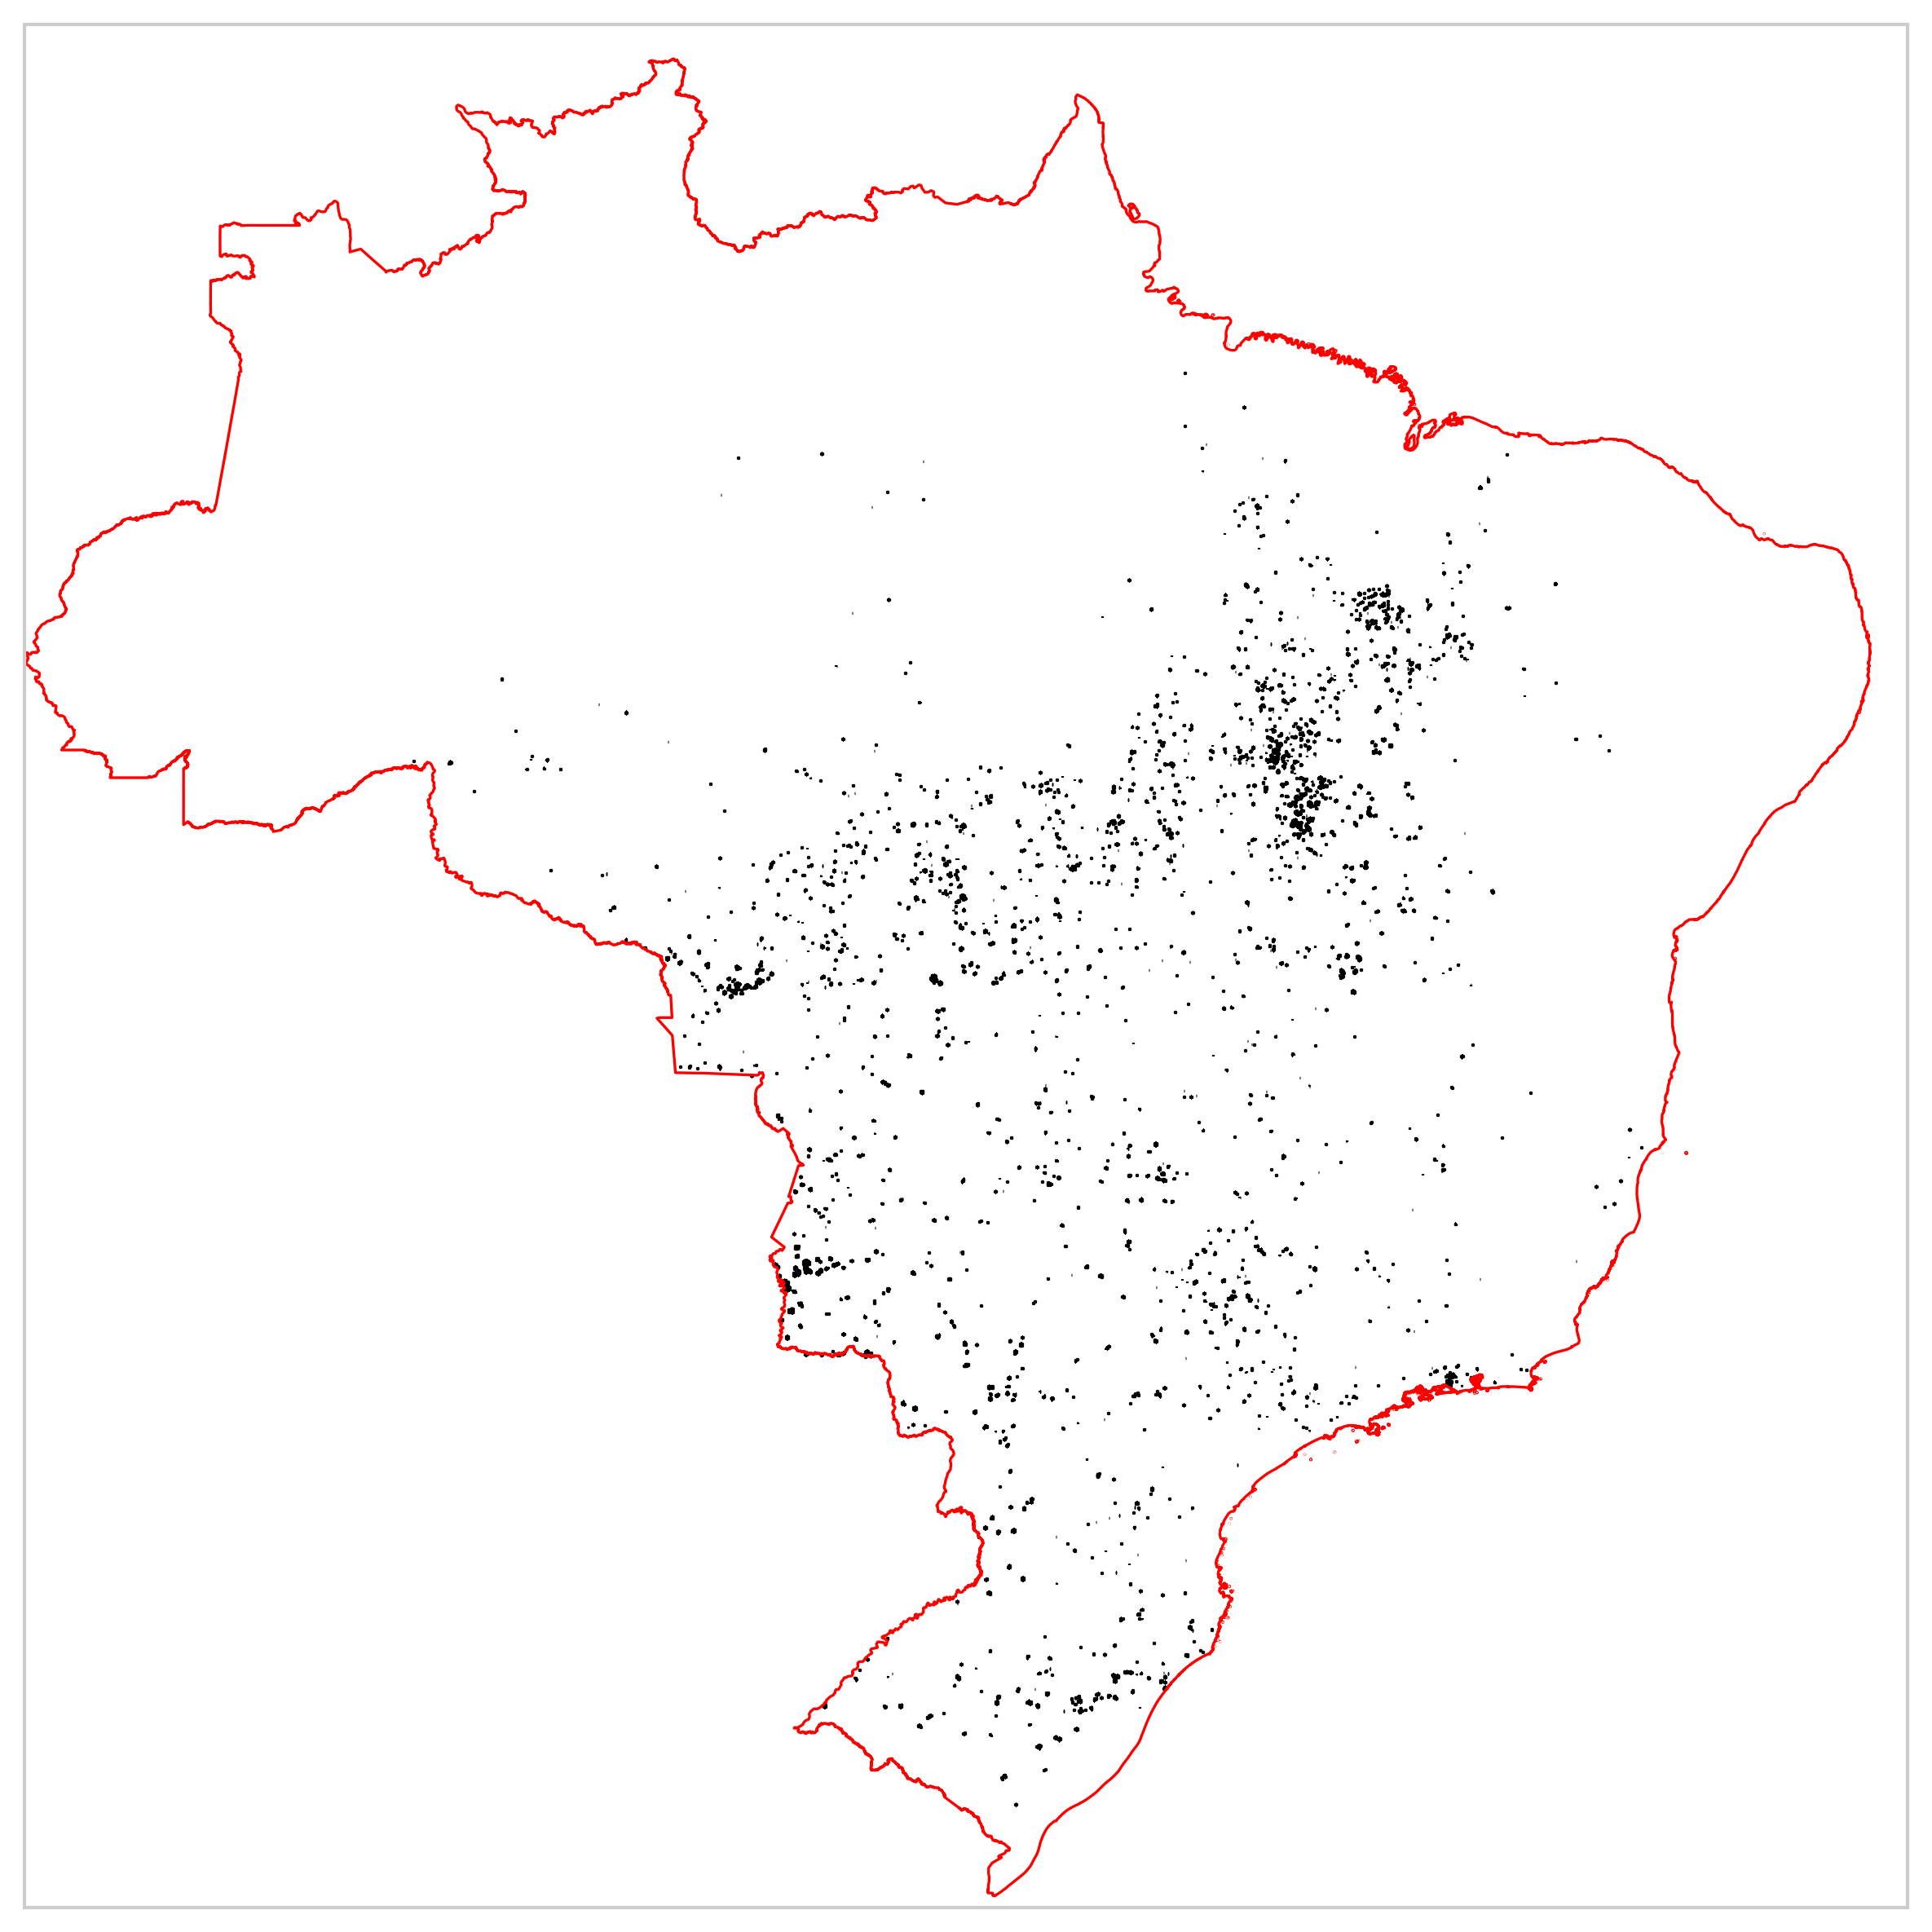

In [19]:
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent(BRAZIL_EXTENT, crs=ccrs.PlateCarree())

for polygon in gdf_within_brazil['geometry']:
    ax.add_geometries([polygon], crs=ccrs.PlateCarree(), facecolor='blue', edgecolor='black')

ax.add_geometries(brazil['geometry'], crs=ccrs.PlateCarree(), facecolor='none', edgecolor='red')

# Add features to the map
# ax.coastlines()
# ax.add_feature(cfeature.BORDERS, linestyle=':')

plt.show()

In [18]:
# m = folium.Map(location=[-23.5, -46.6], zoom_start=5)

# for _, row in gdf.iterrows():
#     # Convert the geometry to GeoJSON
#     geojson = folium.GeoJson(data=row['geometry'],
#                              style_function=lambda x: {'fillColor': 'green', 'color': 'green'})
#     # Add a popup or other features if needed
#     geojson.add_child(folium.Popup(f"DN: {row['DN']}, Date: {row['data']}"))
#     # Add to the map
#     geojson.add_to(m)

# m

.